In [2]:
################ Library imports ################
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.optimize import curve_fit

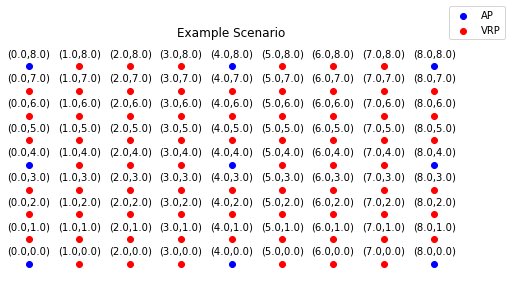

In [3]:
"""
Locations plot
"""
locations = np.array(np.meshgrid(np.linspace(0, 8, 9), np.linspace(0, 8, 9))).T.reshape(-1, 2)

# ----------------------------------------------------------------------
#  AP locations
L_ap = locations[[0,4,8,36,40,44,72,76,80], :]

# ----------------------------------------------------------------------
#  VRP locations
L_vrp = np.delete(locations, [0,4,8,36,40,44,72,76,80], 0)

plt.figure(figsize=(8,4))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Example Scenario',pad=20)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):

    label = f"({x},{y})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [4]:
"""
Compute Euclidean distance vector
    
    target --> Reference AP location to calculate distance
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance_vector(target, array):
    d_vec = np.array([np.linalg.norm(target - i) for (i) in array])
    return d_vec

In [5]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [6]:
"""
RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

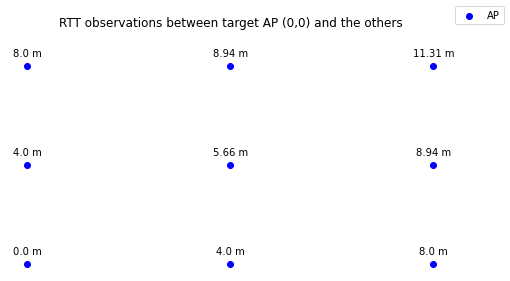

In [45]:
"""
Target AP to compute algorithm: AP[0,0]

Let's assume an euclidean distance as RTT distance observations
""" 
d_RTT = compute_euclidean_distance_vector(L_ap[0], L_ap)

plt.figure(figsize=(8,4))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')

plt.legend(labels=['AP'],loc="upper right",borderaxespad=-5)
plt.title('RTT observations between target AP (0,0) and the others',pad=30)
plt.axis('off')

for x,y in zip(L_ap[:,0],L_ap[:,1]):
    label = f"{compute_euclidean_distance_vector(L_ap[0], np.array([[x,y]]))[0].round()} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [8]:
"""
Surface fitting models
"""

# Plot domain
X,Y = np.meshgrid(np.arange(0.0, 9.0, 1), np.arange(0.0, 9.0, 1))

#Model fitting and surface estimation
model_1 = surface_fit(L_ap, d_RTT)
model_2 = surface_fit(L_ap, d_RTT, 2)

Z_1 = sample_distance(X, Y, model_1)
Z_2 = sample_distance(X, Y, model_2)

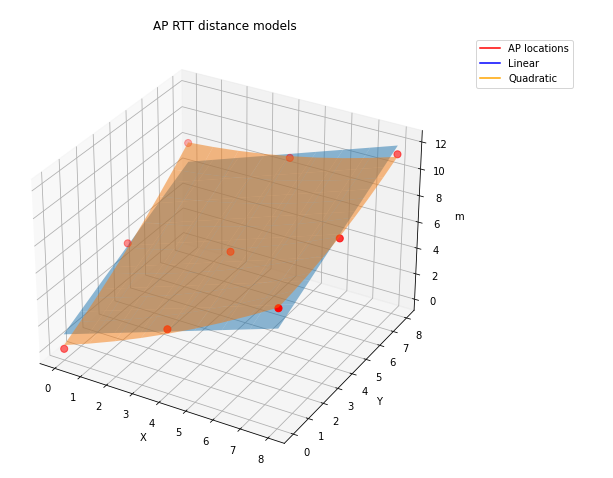

In [9]:
"""
Surface fitting plot
"""
fig = plt.figure(figsize=(12,8))

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1, rstride=1, cstride=1, alpha=0.5, label='linear')
l2 = ax.plot_surface(X, Y, Z_2, rstride=1, cstride=1, alpha=0.5, label='quadratic')

ax.scatter(L_ap[:,0], L_ap[:,1], d_RTT, c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

line_labels = ["AP locations","Linear", "Quadratic"]

ax.plot([0], [0], color="red")[0]
ax.plot([0], [0], color="blue")[0]
ax.plot([0], [0], color="orange")[0]

fig.legend(labels= line_labels,loc="upper right",borderaxespad=4)

plt.title('AP RTT distance models')
plt.show()

In [10]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.reshape(Z_1, (81,1))
fit_2 = np.reshape(Z_2, (81,1))

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and the rest
m_ap_1 = fit_1[[0,4,8,36,40,44,72,76,80], :]
m_ap_2 = fit_2[[0,4,8,36,40,44,72,76,80], :]

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and VRPs
m_vrp_1 = np.delete(fit_1, [0,4,8,36,40,44,72,76,80], 0)
m_vrp_2 = np.delete(fit_2, [0,4,8,36,40,44,72,76,80], 0)

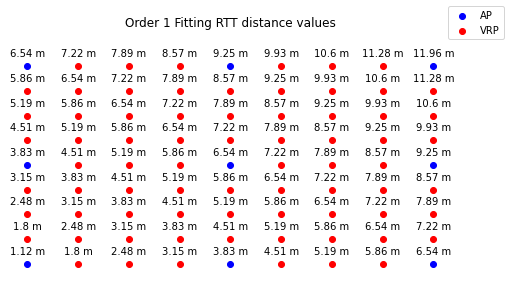

In [69]:
"""
Order 1 RTT distance plot
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""
plt.figure(figsize=(8,4))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Order 1 Fitting RTT distance values',pad=30)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):
    label = f"{sample_distance(x, y, model_1).round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

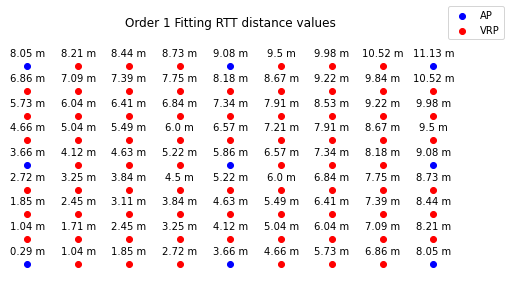

In [70]:
"""
Order 1 RTT distance plot
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""
plt.figure(figsize=(8,4))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Order 2 Fitting RTT distance values',pad=30)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):
    label = f"{sample_distance(x, y, model_2).round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center